# Bio-JEPA AC 

Based on [V-JEPA 2 AC](https://arxiv.org/abs/2506.09985)

**Updates**
The main update here is to do pre-train an action-free model. This means we'll run masked training on the student/teacher model then freeze those and train the action predictor after. 

In pretraining we'll used the MaskedPredictor instead of the ActionPredictor to help drive training of the latent space. 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import copy
import math
import numpy as np
import glob
import os
import json
from pathlib import Path
import matplotlib.pyplot as plt
import random
from dataclasses import dataclass

In [2]:
torch.manual_seed(1337)
random.seed(1337)

In [3]:
!nvidia-smi

/bin/bash: nvidia-smi: command not found


In [4]:
torch.cuda.is_available()

False

In [5]:
def get_device():
    device = 'cpu'
    if torch.cuda.is_available():
        torch.cuda.manual_seed(1337)
        device = 'cuda'
    print(f'using {device}')
    return device

DEVICE = get_device()

using cpu


## Components

### Multi-Headed Attention

In [6]:
class BioMultiHeadAttention(nn.Module):
    # mirrors nn.MultiheadAttention(dim, heads, batch_first=True) 
    def __init__(self, config):
        super().__init__()
        self.config = config

        assert config.embed_dim % config.heads == 0
        
        self.head_dim = config.embed_dim // config.heads
        self.heads = config.heads
        
        # Projections
        self.q_proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.k_proj = nn.Linear(config.embed_dim, config.embed_dim)
        self.v_proj = nn.Linear(config.embed_dim, config.embed_dim)
        
        self.c_proj = nn.Linear(config.embed_dim, config.embed_dim)

    def forward(self, x):
        B, T, C = x.size() # Batch, Seq, Embed Dim
        
        # 1. Project
        q = self.q_proj(x).view(B, T, self.heads, self.head_dim).transpose(1, 2)
        k = self.k_proj(x).view(B, T, self.heads, self.head_dim).transpose(1, 2)
        v = self.v_proj(x).view(B, T, self.heads, self.head_dim).transpose(1, 2)

        # 2. Standard Scaled Dot Product Attention (Permutation Invariant)
        y = F.scaled_dot_product_attention(q, k, v, is_causal=False)
        
        # 5. Reassemble
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.c_proj(y)
        
        return y

### MLP

In [7]:
class MLP(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.c_fc = nn.Linear(config.embed_dim, int(config.mlp_ratio * config.embed_dim))
        self.gelu = nn.GELU(approximate='tanh')
        self.c_proj = nn.Linear(int(config.mlp_ratio * config.embed_dim), config.embed_dim)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        return x

### Hidden Transfomer Block

In [8]:
class CellStateBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.ln_1 = nn.LayerNorm(config.embed_dim)
        self.attn = BioMultiHeadAttention(config)
        self.ln_2 = nn.LayerNorm(config.embed_dim)
        self.mlp = MLP(config)

    def forward(self, x):
        # 1. Attention 
        x = x + self.attn(self.ln_1(x))

        # 2. MLP
        x = x + self.mlp(self.ln_2(x))
        return x

### Cell State Encoder

In [9]:
@dataclass
class CellStateEncoderConfig:
    num_genes: int = 8192
    num_pathways: int = 1024 
    n_layer: int = 24 
    heads: int = 12
    embed_dim: int = 768
    mlp_ratio: float = 4.0 # Changed to float for precision
    mask_matrix: np.ndarray = None 

class CellStateEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Learnable Network, initialized based on known pathwasy 1 == connection
        # wrapping as a "parameter" allows it to be learned
        assert config.mask_matrix is not None, 'Must provide binary_pathway_mask!'
        init_weights = torch.tensor(config.mask_matrix).float().T 
        self.pathway_weights = nn.Parameter(init_weights)
        
        # Learnable Gene Embeddings [num_genes, Dim]
        self.gene_embeddings = nn.Parameter(torch.randn(config.num_genes, config.embed_dim) * 0.02)
        
        # Context Injector
        self.total_count_proj = nn.Linear(1, config.embed_dim)

        # Transfomer
        self.blocks = nn.ModuleList([CellStateBlock(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.embed_dim)

        # Initiation 
        self.apply(self._init_weights)


    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None: 
                torch.nn.init.zeros_(module.bias)
        
    def forward(self, x_genes, x_total_ct):
        # 1. Project Genes
        x_genes = x_genes.unsqueeze(-1) 
        gene_repr = x_genes * self.gene_embeddings.unsqueeze(0)

        # 2. Gene Embeddings @ pathway weights
        x_pathway = self.pathway_weights @ gene_repr

        # 3. Context Injection
        x_total_ct = x_total_ct.unsqueeze(-1)
        x_total_ct = self.total_count_proj(x_total_ct)
        x_total_ct = x_total_ct.unsqueeze(1)
        x = x_pathway + x_total_ct

        # 4. Set Transformer
        for block in self.blocks:
            x = block(x)
        
        # 5. Layer Norm
        x = self.ln_f(x)

        return x

### Adaptive Layer Normalization AdaLN

In [10]:
class AdaLN(nn.Module):
    '''
    Adaptive Layer Norm for conditioning the predictor on action embeddings.
    The action vector regresses the Scale (gamma) and Shift (beta) of the normalization.
    '''
    def __init__(self, embed_dim, action_embed_dim):
        super().__init__()
        self.norm = nn.LayerNorm(embed_dim, elementwise_affine=False)
        self.action_mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(action_embed_dim, 2 * embed_dim)
        )
        # Initialize to identity (gamma=0, beta=0 originally, effectively gamma=1 after logic)
        # Zero-init the last layer so the action starts as a "no-op" (identity)
        nn.init.zeros_(self.action_mlp[1].weight)
        nn.init.zeros_(self.action_mlp[1].bias)

    def forward(self, x, action_emb):
        # x: [Batch, Seq, Dim]
        # action_emb: [Batch, action_embed_dim]
        
        # Project action to style: [B, 2*D] -> [B, 1, 2*D]
        style = self.action_mlp(action_emb).unsqueeze(1) 
        gamma, beta = style.chunk(2, dim=-1)
        
        # Apply affine transformation based on action
        return self.norm(x) * (1 + gamma) + beta

### Action Predictor Block

In [11]:
class PredictorBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # 1. Conditioning (AdaLN) replaces standard LayerNorm
        self.ada_ln1 = AdaLN(config.embed_dim, config.action_embed_dim)
        
        # 2. Attention (Using the shared BioMultiHeadAttention)
        self.attn = BioMultiHeadAttention(config)
        
        # 3. Conditioning (AdaLN) for the MLP block
        self.ada_ln2 = AdaLN(config.embed_dim, config.action_embed_dim)
        
        # 4. MLP (Using the shared MLP)
        self.mlp = MLP(config)

    def forward(self, x, action_emb):
        # 1. AdaLN -> Attention  -> Residual
        x_norm = self.ada_ln1(x, action_emb)
        x = x + self.attn(x_norm)
        
        # 2. AdaLN -> MLP -> Residual
        x_norm = self.ada_ln2(x, action_emb)
        x = x + self.mlp(x_norm)
        
        return x

### Main Predictor Model

In [12]:
@dataclass
class ACPredictorConfig:
    num_pathways: int = 1024
    n_layer: int = 6 
    heads: int = 4
    embed_dim: int = 384
    action_embed_dim: int = 256 
    mlp_ratio: float = 4.0
    max_perturb: int = 2058 ## eventually try to get to a 2**N power

class ACPredictor(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Action Embedding (Discrete ID -> Vector)
        self.action_embed = nn.Embedding(config.max_perturb, config.action_embed_dim)
        
        # Learnable Queries ("Mask Tokens") for the future state
        # One query vector per pathway position
        self.mask_queries = nn.Parameter(torch.randn(1, config.num_pathways, config.embed_dim) * 0.02)
        
        self.blocks = nn.ModuleList([
            PredictorBlock(config) for _ in range(config.n_layer)
        ])
        
        self.final_norm = AdaLN(config.embed_dim, config.action_embed_dim)
        
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, context_latents, action_ids):
        """
        context_latents: [Batch, N, Dim] (From Student Encoder)
        action_ids: [Batch] (Ints)
        """
        B, N, D = context_latents.shape
        
        # 1. Embed Action
        action_emb = self.action_embed(action_ids) # [B, action_embed_dim]
        
        # 2. Construct Input: [Context, Mask_Queries]
        # We concatenate the learned queries to the context. 
        # The predictor will attend to the context to update the queries.
        queries = self.mask_queries.repeat(B, 1, 1) # [B, N, D]
        sequence = torch.cat([context_latents, queries], dim=1) # [B, 2N, D]     
        
        # 3. Pass through AdaLN Blocks
        for block in self.blocks:
            sequence = block(sequence, action_emb)
            
        sequence = self.final_norm(sequence, action_emb)
        
        # 4. Return only the predicted part (The Queries corresponding to N..2N)
        predictions = sequence[:, N:, :] 
        return predictions

### Masked Predictor (pretraining)

In [13]:
class MaskedPredictor(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        
        # Shallow transformer for reconstruction (typically fewer layers than encoder)
        self.blocks = nn.ModuleList([
            CellStateBlock(config) for _ in range(config.n_pre_layer) 
        ])
        self.norm = nn.LayerNorm(config.embed_dim)
        self.pred_head = nn.Linear(config.embed_dim, config.embed_dim)

        self.apply(self._init_weights)
    def _init_weights(self, module):
        ## fan_in, _ = nn.init._calculate_fan_in_and_fan_out(w)
        ##std = math.sqrt(2.0 / fan_in)
        if isinstance(module, nn.Linear) or isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None: 
                torch.nn.init.zeros_(module.bias)
            
    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        x = self.norm(x)
        x = self.pred_head(x)
        return x

## Bio-JEPA AC

In [14]:
@dataclass
class BioJepaConfig:
    mask_matrix: np.ndarray
    num_genes: int = 8192
    num_pathways: int = 1024
    n_layer: int = 6
    heads: int = 4
    embed_dim: int = 256
    action_embed_dim: int=256 
    mlp_ratio: float = 4.0
    max_perturb: int= 2058 ## eventually try to get to a 2**N power

    # pretraining
    mask_ratio: float = 0.6
    n_pre_layer: int = 3
    
class BioJepa(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        enc_conf = CellStateEncoderConfig(
            num_genes=config.num_genes,
            num_pathways=config.num_pathways,
            n_layer=config.n_layer,
            heads=config.heads,
            embed_dim=config.embed_dim,
            mlp_ratio=config.mlp_ratio,
            mask_matrix=config.mask_matrix
        )
        
        self.student = CellStateEncoder(enc_conf)   
        self.teacher = copy.deepcopy(self.student)
        
        # Freeze teacher
        for p in self.teacher.parameters():
            p.requires_grad = False

        ## Action Predictor
        pred_conf = ACPredictorConfig(
            num_pathways=config.num_pathways,
            n_layer=config.n_layer,
            heads=config.heads,
            embed_dim=config.embed_dim,
            action_embed_dim=config.action_embed_dim,
            mlp_ratio=config.mlp_ratio,
            max_perturb=config.max_perturb
        )
        self.predictor = ACPredictor(pred_conf)

        ## Pretraining 
        self.mask_token = nn.Parameter(torch.randn(1, 1, config.embed_dim) * 0.02)

        mask_pred_conf = copy.deepcopy(enc_conf)
        mask_pred_conf.n_pre_layer = config.n_pre_layer
        self.masked_predictor = MaskedPredictor(mask_pred_conf)

    def forward(self, x_control, total_control, x_case, total_case, action_id):
        # 1. Teacher
        with torch.no_grad():
            target_latents = self.teacher(x_case, total_case)
            
        # 2. Student 
        context_latents = self.student(x_control, total_control)
        
        # 3. Predictor 
        predicted_latents = self.predictor(context_latents, action_id)
        
        # 4. Latent Loss (L1)
        loss = F.l1_loss(predicted_latents, target_latents)
        
        return loss

    def forward_pretrain(self, x, x_total_ct):
        batch = x.shape[0]
        num_pathways = self.config.num_pathways
        
        # 1. Teacher Target (Full view)
        with torch.no_grad():
            target_latents = self.teacher(x, x_total_ct) # [B, N, D]

        # 2. Manual Student Overwrite for masking
        x_genes = x.unsqueeze(-1) 
        gene_repr = x_genes * self.student.gene_embeddings.unsqueeze(0)
        x_pathway = self.student.pathway_weights @ gene_repr # [B, N, D]
        
        x_total_ct = x_total_ct.unsqueeze(-1)
        x_total_ct = self.student.total_count_proj(x_total_ct)
        x_total_ct = x_total_ct.unsqueeze(1)
        x = x_pathway + x_total_ct
        
        # 3. Create Mask for learning 1 = Masked, 0 = Visible
        mask_noise = torch.rand(batch, num_pathways, device=x.device)
        mask_indices = mask_noise < self.config.mask_ratio
        
        # Replace masked tokens with self.mask_token
        # Expand mask token to [B, N, D] then select positions
        mask_token_expand = self.mask_token.expand(batch, num_pathways, -1)
        x_masked = x.clone()
        x_masked[mask_indices] = mask_token_expand[mask_indices]

        # 4. Pass through Student Transformer Blocks
        for block in self.student.blocks:
            x_masked = block(x_masked)
        z_student = self.student.ln_f(x_masked)
        
        # 5. Masked Predictor tries to reconstruct the teacher latent at the masked positions
        z_pred = self.masked_predictor(z_student)
        
        # 6. Loss calculation (Compute loss ONLY on masked patches)
        pred_masked = z_pred[mask_indices]
        target_masked = target_latents[mask_indices]
        
        loss = F.l1_loss(pred_masked, target_masked)
        
        return loss 

    @torch.no_grad()
    def update_teacher(self, m=0.996):
        for param_s, param_t in zip(self.student.parameters(), self.teacher.parameters()):
            param_t.data.mul_(m).add_((1 - m) * param_s.data)
            

## Training

#### Prep

In [15]:
data_dir = Path('/Users/djemec/data/jepa/v0_2')
train_dir = data_dir / 'training'
pretrain_dir = data_dir / 'pretraining'
mask_path = data_dir / 'binary_pathway_mask.npy'
metadata_path = data_dir / 'perturbation_map.json'
checkpoint_dir = data_dir / 'checkpoint'

In [16]:
print('Loading Pathway Mask...')
binary_mask = np.load(mask_path)
N_GENES, N_PATHWAYS = binary_mask.shape
print(f'Mask Loaded: {N_GENES} Genes -> {N_PATHWAYS} Pathways')

Loading Pathway Mask...
Mask Loaded: 5000 Genes -> 1024 Pathways


In [17]:
BATCH_SIZE = 32
n_embd = 8
n_pathways = 1024
EPOCHS = 5
training_file_chunk = 25000
pretraining_file_chunk = 50000
n_heads = 1
n_layers = 1

In [18]:
def load_pretrain_shard(filename):
    print(f'loading {filename}') # Optional: reduce noise
    with np.load(filename) as data:
        x = data['x'].astype(np.float32)
        total = data['total'].astype(np.float32)
    return x, total


class PTDataLoaderLite:
    def __init__(self, B, split, device):
        self.B = B
        self.split = split
        self.device = device
        
        data_root = pretrain_dir / f'{split}'
        shards = sorted(list(data_root.glob('*.npz')))

        self.total_files = len(shards)
        self.shards = sorted(shards)
        
        print(f'Found {len(self.shards)} pretrain shards')
        self.reset()

    def reset(self):
        self.remaining_shards = list(self.shards)
        random.shuffle(self.remaining_shards)
        
        self.current_shard_idx = -1
        self.load_next_shard()

    def load_next_shard(self):
        self.current_shard_idx += 1
        
        if self.current_shard_idx >= len(self.remaining_shards):
            self.reset()
            return

        filename = self.remaining_shards[self.current_shard_idx]
        self.data_tuple = load_pretrain_shard(filename)


        n_samples = len(self.data_tuple[0])
        self.perm = np.random.permutation(n_samples)
        self.current_position = 0
        self.total_samples_in_shard = n_samples

    def next_batch(self):
        if self.current_position + self.B > self.total_samples_in_shard:
            self.load_next_shard()
            return self.next_batch()
            
        indices = self.perm[self.current_position : self.current_position + self.B]
        self.current_position += self.B
        
        batch_x = torch.from_numpy(self.data_tuple[0][indices]).to(self.device)
        batch_tot = torch.from_numpy(self.data_tuple[1][indices]).to(self.device)
        return batch_x, batch_tot
    

In [19]:
def load_shard(filename):
    print(f'loading {filename}') # Optional: reduce noise
    with np.load(filename) as data:
        # Load all arrays into memory
        # We convert to correct types immediately to save hassle later
        control_x = data['control'].astype(np.float32)
        control_tot = data['control_total'].astype(np.float32)
        case_x = data['case'].astype(np.float32)
        case_tot = data['case_total'].astype(np.float32)
        action_ids = data['action_ids'].astype(np.int64)
        
    return control_x, control_tot, case_x, case_tot, action_ids

class DataLoaderLite:
    def __init__(self, B, split, device):
        self.B = B
        self.split = split
        self.device = device
        
        # 1. Find Shards
        data_root = train_dir / f'{split}'
        shards = list(data_root.glob('*.npz'))

        self.total_files = len(shards)
        self.shards = sorted(shards)

        assert len(shards) > 0, f'no shards found for split {split}'
        print(f'found {len(shards)} shards for split {split}')
        
        self.reset()

    def reset(self):
        # Create a randomized queue of shards
        self.remaining_shards = list(self.shards)
        random.shuffle(self.remaining_shards)
        
        self.current_shard_idx = -1
        self.load_next_shard()

    def load_next_shard(self):
        self.current_shard_idx += 1
        
        # If we ran out of shards, reset (Epoch done)
        if self.current_shard_idx >= len(self.remaining_shards):
            self.reset() # This resets shard_idx to -1 and reshuffles
            return 

        # Load the file
        filename = self.remaining_shards[self.current_shard_idx]
        self.data_tuple = load_shard(filename)
        
        # Shuffle the items INSIDE the shard
        # This is critical so we don't just memorize the sorted order of the shard
        n_samples = len(self.data_tuple[0])
        self.perm = np.random.permutation(n_samples)
        self.current_position = 0
        self.total_samples_in_shard = n_samples

    def next_batch(self):
        B = self.B
        
        # Check if we have enough data left in current shard
        if self.current_position + B > self.total_samples_in_shard:
            self.load_next_shard()
            # Recursively call to get batch from the new shard
            return self.next_batch()
            
        # Get indices for this batch
        indices = self.perm[self.current_position : self.current_position + B]
        self.current_position += B
        
        # Slice data using the shuffled indices
        # data_tuple structure: (xc, xct, xt, xtt, aid)
        batch_xc  = torch.from_numpy(self.data_tuple[0][indices]).to(self.device)
        batch_xct = torch.from_numpy(self.data_tuple[1][indices]).to(self.device)
        batch_xt  = torch.from_numpy(self.data_tuple[2][indices]).to(self.device)
        batch_xtt = torch.from_numpy(self.data_tuple[3][indices]).to(self.device)
        batch_aid = torch.from_numpy(self.data_tuple[4][indices]).to(self.device)
        
        return batch_xc, batch_xct, batch_xt, batch_xtt, batch_aid

## Pretraining

In [20]:
pt_train_loader = PTDataLoaderLite(B=BATCH_SIZE, split='train', device=DEVICE)
pt_val_loader = PTDataLoaderLite(B=BATCH_SIZE, split='val', device=DEVICE)

Found 3 pretrain shards
loading /Users/djemec/data/jepa/v0_2/pretraining/train/pt_shard_k562e_train_0000.npz
Found 1 pretrain shards
loading /Users/djemec/data/jepa/v0_2/pretraining/val/pt_shard_k562e_val_0000.npz


**Model Config**

In [21]:
pt_LR = 1e-3

In [22]:
config = BioJepaConfig(
    mask_matrix=binary_mask, 
    num_genes=N_GENES,
    num_pathways=N_PATHWAYS,
    embed_dim=n_embd,
    n_layer=n_layers,
    heads=n_heads,
    n_pre_layer = n_layers
)
model = BioJepa(config).to(DEVICE)

In [23]:
optimizer = torch.optim.AdamW(model.parameters(), lr=pt_LR, weight_decay=0.05)

In [24]:
train_total = 112373
val_total = 11044
steps_per_epoch = train_total // BATCH_SIZE
max_steps = EPOCHS * steps_per_epoch
steps_per_epoch, max_steps

(3511, 17555)

In [25]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=pt_LR, total_steps=max_steps, pct_start=0.05
)

In [26]:
lossi = []
step = 0
total_epoch_loss = 0

In [27]:
for step in range(max_steps):
    last_step = (step == max_steps - 1)

    # once in a while evaluate our validation set loss
    if step % 100 == 0 or last_step:
        model.eval()
        with torch.no_grad():
            val_loss_accum = 0.0
            val_loss_steps = 10
            for i in range(val_loss_steps):
                x, x_tot = pt_val_loader.next_batch()
                loss = model.forward_pretrain(x, x_tot)
                loss = loss / val_loss_steps
                val_loss_accum += loss.detach()

        print(f'val loss: {val_loss_accum.item():.4f}')
        # with open(log_file, "a") as f:
        #    f.write(f'{step} test {test_loss_accum.item():.4f}\n')


    if step > 0 and (step+1) % steps_per_epoch ==0 and not last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_pt_ckpt_{step}.pt')


    model.train()
    x, x_tot = pt_train_loader.next_batch()
    
    optimizer.zero_grad()
    
    loss = model.forward_pretrain(x, x_tot)
    loss.backward()

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    # Update Teacher (V-JEPA Momentum)
    model.update_teacher()
    
    scheduler.step()
    
    lossi.append(loss.item())
    total_epoch_loss += loss.item()
    
    if step % 25 == 0:
        print(f"Step {step} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.2e}")
    
    
    if step > 0 and (step+1) % steps_per_epoch == 0:   
        avg_loss = total_epoch_loss / steps_per_epoch
        print(f"=== Step {step} Done. Avg Loss: {avg_loss:.5f} ===")
        total_epoch_loss = 0
    
    
    if last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_pt_ckpt_{step}_final.pt')

    step += 1



val loss: 0.8116
Step 0 | Loss: 0.81103 | LR: 4.00e-05
Step 25 | Loss: 0.80286 | LR: 4.21e-05
Step 50 | Loss: 0.79484 | LR: 4.80e-05
Step 75 | Loss: 0.78962 | LR: 5.77e-05
val loss: 0.7853
Step 100 | Loss: 0.78509 | LR: 7.11e-05
Step 125 | Loss: 0.77757 | LR: 8.81e-05
Step 150 | Loss: 0.76784 | LR: 1.09e-04
Step 175 | Loss: 0.75743 | LR: 1.32e-04
val loss: 0.7434
Step 200 | Loss: 0.74366 | LR: 1.59e-04
Step 225 | Loss: 0.72618 | LR: 1.89e-04
Step 250 | Loss: 0.71116 | LR: 2.21e-04
Step 275 | Loss: 0.69664 | LR: 2.56e-04
val loss: 0.6753
Step 300 | Loss: 0.67437 | LR: 2.93e-04
Step 325 | Loss: 0.66366 | LR: 3.32e-04
Step 350 | Loss: 0.64208 | LR: 3.72e-04
Step 375 | Loss: 0.63150 | LR: 4.14e-04
val loss: 0.6267
Step 400 | Loss: 0.62972 | LR: 4.56e-04
Step 425 | Loss: 0.62572 | LR: 4.99e-04
Step 450 | Loss: 0.63436 | LR: 5.42e-04
Step 475 | Loss: 0.62558 | LR: 5.85e-04
val loss: 0.6280
Step 500 | Loss: 0.62943 | LR: 6.27e-04
Step 525 | Loss: 0.63518 | LR: 6.68e-04
Step 550 | Loss: 0.6109

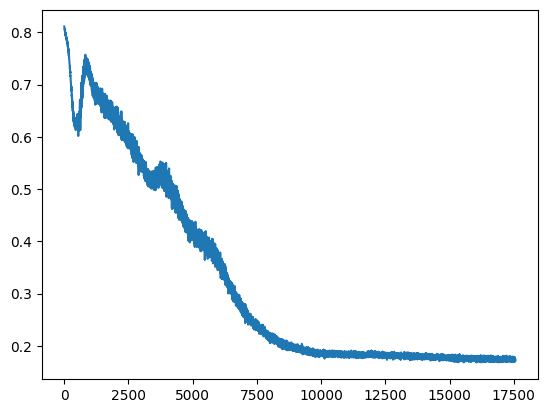

In [30]:
plt.plot(lossi[:])
#plt.yscale('log')

## Training

#### Data Loader

In [31]:
train_loader = DataLoaderLite(B=BATCH_SIZE, split='train', device=DEVICE)
val_loader = DataLoaderLite(B=BATCH_SIZE, split='val', device=DEVICE)

found 5 shards for split train
loading /Users/djemec/data/jepa/v0_2/training/train/shard_k562e_train_0003.npz
found 1 shards for split val
loading /Users/djemec/data/jepa/v0_2/training/val/shard_k562e_val_0000.npz


## Training

#### Optimizer

In [33]:
LR = 1e-3
EPOCHS = 2

In [34]:
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=0.05)

#### Scheduler

In [35]:
steps_per_epoch = 101682 // BATCH_SIZE
max_steps = EPOCHS * steps_per_epoch
steps_per_epoch, max_steps

(3177, 6354)

In [36]:
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=LR, total_steps=max_steps, pct_start=0.05
)

#### Training Loop

In [37]:
lossi = []
step = 0
total_epoch_loss = 0

In [38]:
for step in range(max_steps):

    last_step = (step == max_steps - 1)

    # once in a while evaluate our validation set loss
    if step % 100 == 0 or last_step:
        model.eval()
        with torch.no_grad():
            test_loss_accum = 0.0
            test_loss_steps = 10
            for i in range(test_loss_steps):
                xc, xct, xt, xtt, aid = val_loader.next_batch()
                xc, xct, xt, xtt, aid = xc.to(DEVICE), xct.to(DEVICE), xt.to(DEVICE), xtt.to(DEVICE), aid.to(DEVICE)
                loss = model(xc, xct, xt, xtt, aid)
                loss = loss / test_loss_steps
                test_loss_accum += loss.detach()

        print(f'test loss: {test_loss_accum.item():.4f}')
        # with open(log_file, "a") as f:
        #    f.write(f'{step} test {test_loss_accum.item():.4f}\n')


    if step > 0 and (step+1) % steps_per_epoch ==0 and not last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_ckpt_{step}.pt')


    model.train()
    xc, xct, xt, xtt, aid = train_loader.next_batch()
    xc, xct, xt, xtt, aid = xc.to(DEVICE), xct.to(DEVICE), xt.to(DEVICE), xtt.to(DEVICE), aid.to(DEVICE)
    
    optimizer.zero_grad()
    
    loss = model(xc, xct, xt, xtt, aid)
    loss.backward()

    # gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    
    # Update Teacher (V-JEPA Momentum)
    model.update_teacher()
    
    scheduler.step()
    
    lossi.append(loss.item())
    total_epoch_loss += loss.item()
    
    if step % 25 == 0:
        print(f"Step {step} | Loss: {loss.item():.5f} | LR: {scheduler.get_last_lr()[0]:.2e}")
    
    
    if step > 0 and (step+1) % steps_per_epoch == 0:   
        avg_loss = total_epoch_loss / steps_per_epoch
        print(f"=== Step {step} Done. Avg Loss: {avg_loss:.5f} ===")
        total_epoch_loss = 0
    
    
    if last_step:
        # Save Checkpoint
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'step': step
        }, checkpoint_dir / f'bio_jepa_ckpt_{step}_final.pt')

    step += 1



test loss: 0.8764
Step 0 | Loss: 0.88231 | LR: 4.00e-05
Step 25 | Loss: 0.81160 | LR: 5.59e-05
Step 50 | Loss: 0.70925 | LR: 1.00e-04
Step 75 | Loss: 0.58264 | LR: 1.70e-04
test loss: 0.4879
Step 100 | Loss: 0.48090 | LR: 2.61e-04
Step 125 | Loss: 0.41156 | LR: 3.69e-04
Step 150 | Loss: 0.36638 | LR: 4.85e-04
Step 175 | Loss: 0.27371 | LR: 6.04e-04
test loss: 0.3268
Step 200 | Loss: 0.23954 | LR: 7.17e-04
Step 225 | Loss: 0.17854 | LR: 8.18e-04
Step 250 | Loss: 0.16198 | LR: 9.02e-04
Step 275 | Loss: 0.14191 | LR: 9.61e-04
test loss: 0.2583
Step 300 | Loss: 0.14336 | LR: 9.94e-04
Step 325 | Loss: 0.12087 | LR: 1.00e-03
Step 350 | Loss: 0.11526 | LR: 1.00e-03
Step 375 | Loss: 0.10682 | LR: 1.00e-03
test loss: 0.2336
Step 400 | Loss: 0.09966 | LR: 1.00e-03
Step 425 | Loss: 0.09599 | LR: 9.99e-04
Step 450 | Loss: 0.08897 | LR: 9.99e-04
Step 475 | Loss: 0.08435 | LR: 9.98e-04
test loss: 0.2128
Step 500 | Loss: 0.08807 | LR: 9.98e-04
Step 525 | Loss: 0.06386 | LR: 9.97e-04
Step 550 | Loss: 

#### Training Loss Plot

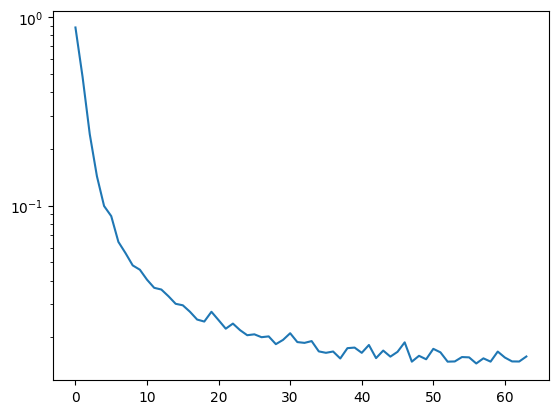

In [39]:
plt.plot(lossi[::100])
plt.yscale('log')

## Test Inference

In [ ]:
val_dir = tok_dir / 'val'
pathway_names_path = data_dir / 'pathway_names.json'
gene_names_path = data_dir / 'gene_names.json'
pathway_names_path, gene_names_path, metadata_path, val_dir

In [ ]:
# 1. Load Map (ID -> Name)
with open(metadata_path, "r") as f:
    pert_map = json.load(f)
id_to_pert = {v: k for k, v in pert_map.items()}

# with open(pathway_names_path, "r") as f:
#     pathway_names = json.load(f) # List of 1024 names

with open(data_dir / 'gene_names.json', "r") as f:
    gene_names = json.load(f)

In [ ]:
model.eval()

**Get random data sample**

In [ ]:
def get_random_test_pair(shard_dir):
    '''Grab a single real pair from a random shard with Context'''
    files = sorted(shard_dir.glob('*.npz'))
        
    file_path = files[np.random.randint(len(files))]
    
    with np.load(file_path) as data:
        idx = np.random.randint(data['action_ids'].shape[0])
        
        # Extract Items (Now 5 items instead of 3)
        c_raw = data['control'][idx]         # [2000]
        ct_raw = data['control_total'][idx]  # Scalar
        case_raw = data['case'][idx]         # [2000]
        caset_raw = data['case_total'][idx]  # Scalar
        act_id = data['action_ids'][idx]     # Scalar
        
    # Convert to Tensor & Add Batch Dim [1, ...]
    xc = torch.tensor(c_raw).float().unsqueeze(0).to(DEVICE)
    xct = torch.tensor(ct_raw).float().unsqueeze(0).to(DEVICE)
    xt = torch.tensor(case_raw).float().unsqueeze(0).to(DEVICE)
    xtt = torch.tensor(caset_raw).float().unsqueeze(0).to(DEVICE)
    aid = torch.tensor([act_id]).long().to(DEVICE)
    
    return xc, xct, xt, xtt, aid

In [ ]:
xc, xct, xt, xtt, aid = get_random_test_pair(val_dir)
pert_name = id_to_pert[aid.item()]
pert_name

In [ ]:
with torch.no_grad():
    # Teacher sees the FUTURE (Real Treated Case)
    # Output: [1, 1024, 384]
    z_case = model.teacher(xt, xtt)       
    
    # Student sees the PAST (Control)
    # Output: [1, 1024, 384]
    z_context = model.student(xc, xct)
    
    # Control Baseline (Where we started in Teacher Space)
    # We run control through teacher to get the "Anchor"
    z_control = model.teacher(xc, xct) 

    # Predictor tries to guess Real from Context + Action
    z_predicted = model.predictor(z_context, aid)

**Analysis**

In [ ]:
# Calculate Latent Movement
delta_latent = (z_predicted - z_control).squeeze(0) # [1024, 384]
delta_latent

In [ ]:
# --- 3. Project "Pathway Energy" back to Genes ---
# We want to score every gene based on how much its parent pathways moved.
# Logic: Gene_Score = Sum(Mask_gp * Magnitude(Pathway_p))
# If a gene is in 5 pathways that all moved violently, that gene is highly implicated.
pathway_magnitudes = delta_latent.norm(dim=1) 
pathway_magnitudes

In [ ]:
# 1. Access the Learnable Weights
# Shape in model: [1024 Pathways, 2000 Genes]
# We use .detach() because we are in eval mode and don't want gradients
weights = model.student.pathway_weights.detach()

# 2. Transpose back to [Genes, Pathways] for the projection
# We use .abs() because a strong negative weight (-5.0) implies 
# just as much biological "impact" as a strong positive one.
routing_matrix = weights.T.abs() # Shape: [2000, 1024]
routing_matrix

In [ ]:
# Project: [ Genes, 1024 Pathways] @ [1024 Magnitudes] -> [ Gene Scores]
# This tells us the "Implied Impact" on each gene
gene_impact_scores = torch.mv(routing_matrix, pathway_magnitudes)

In [ ]:
# --- 4. Get Top Predicted Genes ---
top_k = 10
pred_values, pred_indices = torch.topk(gene_impact_scores, top_k)

In [ ]:
print(f'Based on the pathway changes, the model predicts these genes are most affected:')
for val, idx in zip(pred_values, pred_indices):
    g_name = gene_names[idx.item()]
    print(f"  • {g_name:<10} (Score: {val.item():.4f})")

In [ ]:
# --- 5. REALITY CHECK (The most important part) ---
# Did these genes ACTUALLY change in the real data?
# Let's compare the Model's "Top Genes" vs the Reality's "Top Genes"
# Calculate Real Gene Change (Log Space)
# Shape: [1, 2000]
real_gene_delta = (xt - xc).abs().squeeze(0) 
# Get the Top 10 Genes that REALLY changed
real_values, real_indices = torch.topk(real_gene_delta, top_k)

In [ ]:
print(f'Ground Truth')
for val, idx in zip(real_values, real_indices):
    g_name = gene_names[idx.item()]
    
    # Check if our model also listed this gene in its top 10
    match_icon = "✅" if idx in pred_indices else "❌"
    
    print(f"  {match_icon} {g_name:<10} (Delta: {val.item():.4f})")

In [ ]:
# --- 6. Precision@10 Metric ---
# How many of the Top 10 real genes were in the Top 10 predicted genes?
# (Set intersection)
set_pred = set(pred_indices.tolist())
set_real = set(real_indices.tolist())
overlap = len(set_pred.intersection(set_real))

print(f"\n[Precision @ 10]")
print(f"The model correctly identified {overlap}/10 of the top driver genes.")